<div style="text-align: right">Sachin Umans</div>
<div style="text-align: right">March 2025</div>
<div style="text-align: right">V1.4</div>

# Crash course for the control uninitiated for Systeem & Regeltechniek

## Table of contents
1. <div style="background-color:fuchsia">OLIFANT</div>
99. [Nyquist Criterion](#introduction-to-the-nyquist-criterion)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({ 'text.usetex':        False,              'mathtext.fontset':         'cm',
                      'font.size':          12.0,               'axes.labelsize':           'medium',
                      'xtick.labelsize':    'x-small',          'ytick.labelsize':          'x-small',
                      'axes.grid':          True,               'axes.formatter.limits':    [-3, 6],
                      'grid.alpha':         0.5,                'figure.figsize':           [11.0, 4],
                      'figure.constrained_layout.use': True,    'scatter.marker':           'x',
                      'savefig.dpi':        300,                'savefig.bbox':             'tight',
                      'savefig.pad_inches': 0.05,               'savefig.transparent':      True})

from IPython.display import display, Markdown, HTML

import warnings
warnings.filterwarnings("ignore")

import scipy.signal as signal
import scipy.linalg as sclin
import control as cm

# Time domain
## Systems and differential equations
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*The basics of all things control*

*Systems are all and all is a system.* So you can decribe dynamic processses with physics, then you get equations with time derivatives. So for Linear-Time-Independent (LTI) systems, the differential equation with output $y(t)$ and input $u(t)$ is
$$ \frac{d^n}{d^nt}y + a_1\frac{d^{n-1}}{d^{n-1}t}y + \cdots + a_n y = \frac{d^m}{d^mt}u + b_1\frac{d^{m-1}}{d^{m-1}t}u + \cdots + b_m u.$$
Here, $n$ is called the order of the system.

We want to be able to solve Initial Value Problems (IVPs), because that's cool and it shows us what the system will do from some initial state. This solution is built in two steps, the homogenous solution and satisfying the initial conditions.

The homogenous solution is obtained by equation the left hand side to zero. For this, we'll steal a little ahead from the Laplace transform where
$$ \frac{d^n}{d^nt} \overset{\mathcal{F}}{\rightarrow} s^n. $$
Applying this and eliminating $y$ to obtain the homogenous solution yields
$$\frac{d^n}{d^nt}y + a_1\frac{d^{n-1}}{d^{n-1}t}y + \cdots + a_n y = 0 $$
$$\overset{\mathcal{F},\; \frac{1}{y}}{\rightarrow} s^n + a_1 s^{n-1} + \cdots + a_n = 0. $$
This is a polynomial of order $n$ called **the characteristic polynomial** and we know then it has $n$ roots as well.

These roots, $\lambda_k$, actually form the solution to the homogenous problem, since a polynomial is the product of its roots,
$$ \prod_{k=1}^n (s-\lambda_k).$$
The solution to these types of ODEs are sums of exponentials of the form $c_k e^{\lambda_k t}$, where $c_k$ is determined through the initial condition. Therefore, the complete solution is
$$ y(t) = \sum_{k= 1}^n c_k e^{\lambda_k t} .$$

If all $\mathfrak{R}(\lambda_k) < 0$ then $y(t)$ goes to 0 and the system is stable. The Routh-Hurwitz criterion gives the stability requirements up to the third degree. Stability is guaranteed for systems of order
1. if $a_1 > 0$.
2. if $a_1, a_2 > 0$.
3. if $a_1, a_2, a_3 >0$ and $ a_1a_2 > a_3$.

Real-valued $\lambda_k$ yield an exponential trajectory $e^{\lambda_k t}$. Complex-values come in conjugate pairs so they yield an exponential trajectory multiplied by a cosine. Because $\lambda_k, \lambda_{k+1} = \epsilon \pm j\omega$, the trajectory of this pair becomes $e^{(\epsilon \pm j\omega)t} = e^{\epsilon t} (e^{j\omega t} + e^{-j\omega t}) = e^{\epsilon t} (2\cos(\omega t))$. Play around with the code block here to get a feel for it!


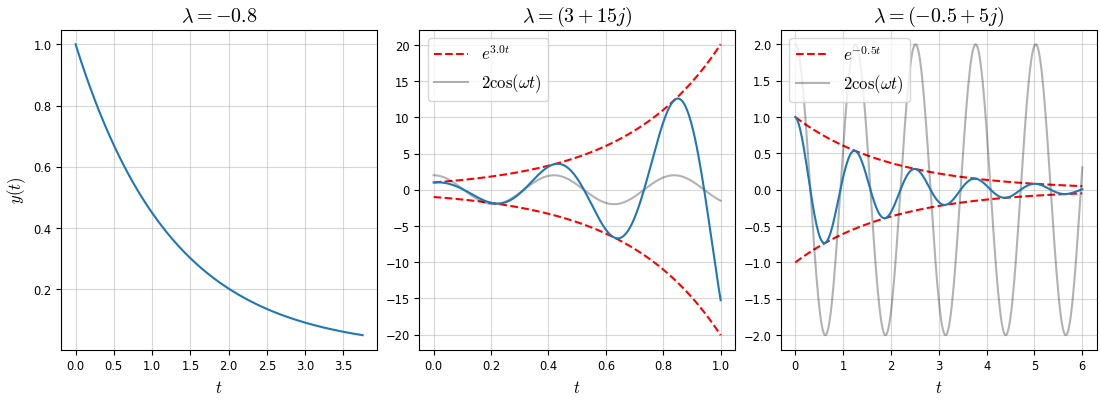

In [3]:
sig1 = -0.8
sig2 = 3 + 15j
sig3 = -0.5 + 5j

###### Processing and Plotting #########
fig, ax = plt.subplots(1,3)
idx = 0
for sig in [sig1, sig2, sig3]:
    t = np.linspace(0, 3/abs(np.real(sig)), num=300)
    if np.iscomplex(sig):
        l1, = ax[idx].plot(t, np.exp(np.real(sig)*t), 'r--', label=f"$e^{r"{"}{np.real(sig)}t{r"}"}$")
        ax[idx].plot(t, -np.exp(np.real(sig)*t), 'r--')
        l2, = ax[idx].plot(t, 2*np.cos(np.imag(sig)*t), 'k', alpha=0.3, label=f"$2\cos(\omega t)$")
        ax[idx].legend(handles=[l1, l2])
    ax[idx].plot(t, np.exp(sig*t))
    ax[idx].set(title=f"$\lambda = {sig}$", xlabel="$t$")
    idx += 1

_ = ax[0].set_ylabel("$y(t)$")


## State space representation
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*A blessing from above*

Cool we know systems now, but it's a bit of an ugly system representation to be honest. Luckily we live in a universe where the state space representation exists and we can recast any system as a vector first order ODE and an output equation. This representation is of the form $$ \dot x = f(x, u)$$ $$ y = h(x, u),$$
where $x$ is the state of the system, $u$ the input, and $y$ the output. The state dynamics are described with $f: \mathbb{R}^n\times\mathbb{R}^p\rightarrow\mathbb{R}^n$ and the output measurements with $h: \mathbb{R}^n\times\mathbb{R}^p\rightarrow\mathbb{R}^q$.

What black magic do we perform to get these first order ODEs? Well, suppose you have a second order ODE in $v$, $\ddot v = \dot v + v$, then this is equivalent to the first order ODE $$ \begin{bmatrix}\dot v\\\ddot v\end{bmatrix}  = \begin{bmatrix}0&1\\1&1\end{bmatrix}\begin{bmatrix}\dot v\\ v\end{bmatrix}.$$ 

Last but not least of the amazing aspects of the state space representation: there are many nice numerical integrators to simulate them. Think forward Euler or Runge-Kutta.

<div style="text-align:center;background-color:tomato;">End of lecture 2 (Lecture 1 was course logistics)</div>

### Block diagrams
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Pixel perfect ways to visualise systems*

<div style="background-color:fuchsia"> [OLIFANT] Insert slide about symbols and elaborate on drawing rules. </div>

It's a nice sanity check that any fundamental block scheme of an $n$-th order system has $n$ integrators.


## Equilibrium points
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Forever and unchanging*

Often, systems will have equilibria, meaning there are states where system will remain over time. These state-input point pairs are denoted as $(x_e, u_e)$ or $(\bar x, \bar u)$. I'll use the latter since this is more traditional in control and we have to appease our control elders (JW). So equilibria remain unchanging, so the derivative of the state is zero. In mathematicians' language
$$ \dot{\bar x} = f(\bar x, \bar u) = 0. $$
Finding the equilibria states as a function of the equilibria inputs is as simple as solving this equation.





<div style="text-align:center;background-color:tomato;">End of lecture 3</div>

## Linearisation
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*The linear life lifts all spirits*

The general state space representation doesn't have so many assumptions, which is great, however, it's also not very useful for analysis. Now we will assume something that **very** often isn't true, but most of control science is built around this wonderful assumption: *linearity*. There is an easy solution for systems that aren't linear, linearisation and forget anything ever happened!

Linearisation isn't super difficult: it's just a first order Taylor expansion of $f$ around an equilibrium point. So
$$f(x,u) \approx f(\bar x, \bar u) + \underbrace{\left.\frac{\partial f(x,u)}{\partial x}\right|_{(\bar x, \bar u)}}_A \underbrace{(x-\bar x)}_x + \underbrace{\left.\frac{\partial f(x,u)}{\partial u}\right|_{(\bar x, \bar u)}}_B \underbrace{(u-\bar u)}_u$$
$$h(x,u) \approx h(\bar x, \bar u) + \underbrace{\left.\frac{\partial h(x,u)}{\partial x}\right|_{(\bar x, \bar u)}}_C \underbrace{(x-\bar x)}_x + \underbrace{\left.\frac{\partial h(x,u)}{\partial u}\right|_{(\bar x, \bar u)}}_D \underbrace{(u-\bar u)}_u.$$
If we are extremely intelligent, we can translate $f$ beforehand such that $f(\bar x, \bar u)=0$, perform the underbraced substitutions, and commit some proper notation heresy to end up with the pretties equation of all: *the linear state space*
$$ \dot x = A x + B u $$
$$ y = C x + D u .$$

$\frac{\partial f(x,u)}{\partial x}$ is called the Jacobian of $f$. A nice memory support is to remember that the Jacobian is multiplied with the state from the right such that each state derivative is multiplied with the same state, so the states vary horizontally and the function elements vertically.

## Stability
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Most control engineers aren't as stable as their systems*

If you know epsilon-delta proofs, I'm sorry for your loss. There is an epsilon-delta definition of stability in the slides, have fun. For normal people stability means that a certain system trajectory stays bounded under bounded disturbances. Even simpler: a stable system always returns to certain points. The stability of certain equilibria is easy to assess, since the linearisation is a good approximation locally at the equilibrium point, the stability of the linearised system indicates the stability of the equilibrium point too.

### Stability of linear systems
So assessing the stability of linear systems is important for all types of systems. Before, we already saw some notions of stability in the context of the characteristic polynomial of systems. There are two interesting relations there:
1. The characteristic polynomial is equivalent to det($sI-A$) for complex $s$.
2. The roots of the characteristic polynomial are equivalent to the eigenvalues of $A$.

That second point sounds familiar! We already saw stability related to the roots of the characteristic polynomial before. So, the eigenvalues, $\Lambda$, of $A$ reveal the stability of the system. Surprisingly though, there are three types of stability, not two:
1. Unstable $\leftarrow \exist\mathfrak{R}(\lambda)>0, \lambda\in\Lambda$.
2. Neutrally stable $\leftarrow \mathfrak{R}(\lambda)\leq 0, \forall\lambda\in\Lambda$ with at most one eigenvalue at 0 or on conjugate pair with real part 0.
3. Assymptotically stable $\leftarrow \mathfrak{R}(\lambda)\leq 0, \forall\lambda\in\Lambda$.

These things are nicely visualised for two dimensional system, so you can guess it: have look at the code block!

Eigenvalues are [-0.25+2.2220486j -0.25-2.2220486j]
Eigenvectors are [[ 0.91287093+0.j          0.91287093-0.j        ]
 [-0.04564355+0.40568871j -0.04564355-0.40568871j]]


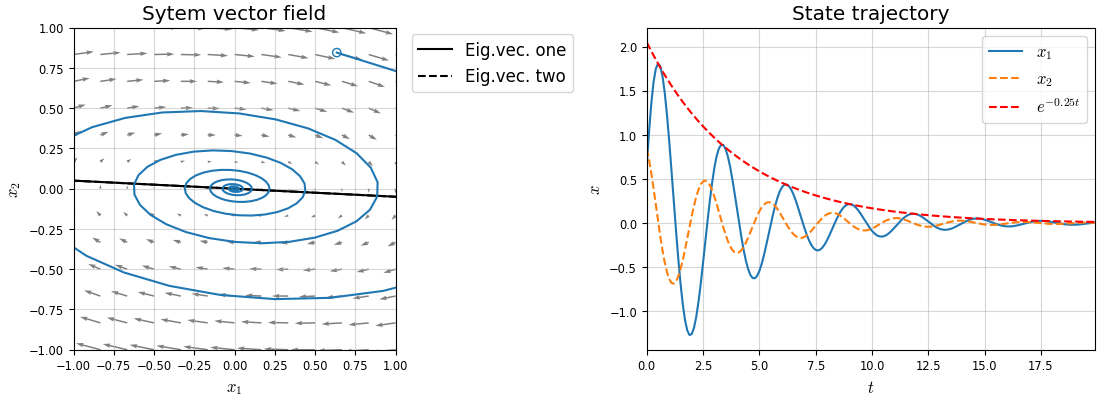

In [59]:
if True: # Toggle between defining A or eigenvalues
    A = np.array([[0, 5],
                [-1, -.5]])
else:
    if 'A' in locals(): del A
    if 'v1' in locals(): del v1, v2

    lambda1 = -1
    lambda2 = -.1

    ## Optionally, you can also define the eigenvectors, otherwise they're random and perpendicular
    # v1 = np.array([[1],[1]])
    # v2 = np.array([[1],[-1]])

###### Processing and Plotting #########
import numpy.random as rng
import numpy.linalg as lin

def RK4(x, dx, h):
    k1 = dx(x)
    k2 = dx(x+h*k1/2)
    k3 = dx(x+h*k2/2)
    k4 = dx(x+h*k3)
    xp = x + h/6*(k1 + 2*k2 +2*k3 + k4)
    return xp

if 'A' not in locals():
    if 'v1' not in locals():
        v1 = rng.randn(2, 1)
        v2 = np.array([[0,-1],[1, 0]])@v1

    T = np.append(v1, v2, axis=1)
    A = T@np.diag([lambda1, lambda2])@lin.inv(T)
    print(f"A is {A}")
else:
    e, v = lin.eig(A)
    print(f"Eigenvalues are {e}")
    print(f"Eigenvectors are {v}")
    v1 = v[:,0][:,np.newaxis]
    v2 = v[:,1][:,np.newaxis]
    lambda1 = e[0]
    lambda2 = e[1]

def vector_field(A, ax, n=8):
    X = np.linspace(-1, 1, num=n, endpoint=True)
    Y = np.linspace(-1, 1, num=n, endpoint=True)

    U = np.empty([n, n])
    V = np.empty([n, n])

    idx1 = 0
    for x in X:
        idx2 = 0
        for y in Y:
            dx = A@np.array([[x],[y]])
            U[idx2, idx1] = dx[0, 0]
            V[idx2, idx1] = dx[1, 0]
            idx2+=1
        idx1+=1
    
    ax.quiver(X, Y, U, V, color='tab:gray')
    l1, =ax.plot([0,  20*v1[0,0]], [0,  20*v1[1,0]], 'k', label="Eig.vec. one")
    l2, =ax.plot([0,  20*v2[0,0]], [0,  20*v2[1,0]], 'k--', label="Eig.vec. two")
    _,  =ax.plot([0, -20*v1[0,0]], [0, -20*v1[1,0]], 'k')
    _,  =ax.plot([0, -20*v2[0,0]], [0, -20*v2[1,0]], 'k--')
    ax.set(xlim=[-1,1], ylim=[-1,1], xlabel="$x_1$", ylabel="$x_2$")
    ax.legend(handles=[l1, l2], loc=(1.05, .8))


fig, ax = plt.subplots(1,2)
ax[0].set(aspect="equal", title="Sytem vector field")
vector_field(A, ax[0], n=13)

## Create trajectory
traj = np.full([2, 200], np.nan)
traj[:,[0]] = rng.rand(2,1)
h = 0.1
for idx in range(max(traj.shape)-1):
    traj[:, idx+1] = RK4(x=traj[:, idx], dx=lambda x: A@x, h=h)
_ = ax[0].plot(traj[0,:], traj[1,:])
_ = ax[0].scatter(traj[0,0], traj[1,0], marker='o', color='tab:blue', facecolors='none')

T = np.arange(max(traj.shape))*h
l1, = ax[1].plot(T, traj[0,:], label="$x_1$")
l2, = ax[1].plot(T, traj[1,:], '--', label="$x_2$")

if np.iscomplex(lambda1):
    peakIdx, _ = signal.find_peaks(traj[0,:])
    l3, = ax[1].plot(T, traj[0,peakIdx[0]]*np.exp((T-T[peakIdx[0]])*np.real(lambda1)), 'r--', label=f"$e^{"{"}{np.real(lambda1)}t{"}"}$")
    ax[1].legend(handles=[l1,l2,l3])
else:
    ax[1].legend(handles=[l1,l2])

_ = ax[1].set(xlim=[0, max(T)], title="State trajectory", xlabel="$t$", ylabel="$x$")


### How to be an eigenvalue wizard
Ever had *one of those people* look at a matrix and fully describe its behaviour in a second. Then you check and they're right and you have to take a moment to contemplate if that imposter syndrome might not be as fake as you hoped? Yeah...

Anyways here are some tricks:
1. A diagonal matrix has its eigenvalues on the diagonal.
2. A triangular matrix also has its eigenvalues on the diagonal.
3. Block diagonal matrices are the union of the eigenvalues of the blocks.
4. Have a look at the [Jordan normal form](https://en.wikipedia.org/wiki/Jordan_normal_form) if you want, it's also triangular.
5. The sum of all eigenvalues is the trace of the matrix.
6. The product of all eigenvalues is the determinant of the matrix.
7. If $\lambda_k$ are the eigenvalues of $A$, then the eigenvalues of $A^{-1}$ are $1/\lambda_k$.

## Coordinate transform
Sometimes we want to change the coordinate base of our states, either to give them physical meaning or to cast $A$ into a simpler form. This is rather easy linear algebra, lets say the new state $z=Tx \rightarrow x = T^{-1}z$. Then we can substitute that into the state space representation
$$ \dot x = Ax + Bu \rightarrow T^{-1}\dot z = AT^{-1}z + Bu \rightarrow \dot z = \underbrace{TAT^{-1}}_{\tilde A} z + \underbrace{TB}_{\tilde B}u = \tilde A z + \tilde B u.$$
and $$ y = Cx + Du \rightarrow y = \underbrace{CT^{-1}}_{\tilde C}z + Du = \tilde C z + Du.$$
**Important: note that the input/output behaviour remains unchanged under state transformations. This is only a system-internal operation.**

For $A$ with unique eigenvalues, the system is called diagonalisable, because taking the inverse transformation, $T^{-1}$, to be the horizontally stacked eigenvectors of $A$ results in a diagonal $\tilde A$. Sometimes stuff is named nice and descriptive.

<div style="text-align:center;background-color:tomato;">End of lecture 4</div>

## Textbook input signals
To generally see how a system output behaves in time, there are two standard signals we like to use:
1. the Dirac-delta impulse signal
2. and the (Heaviside) step signal.

The impulse signal is primarily used to see the transient behaviour of the system and the step functions shows the transient and steady state behaviour. Look at these plots to see! We're even able to seperate the transient from the steady state for the step!

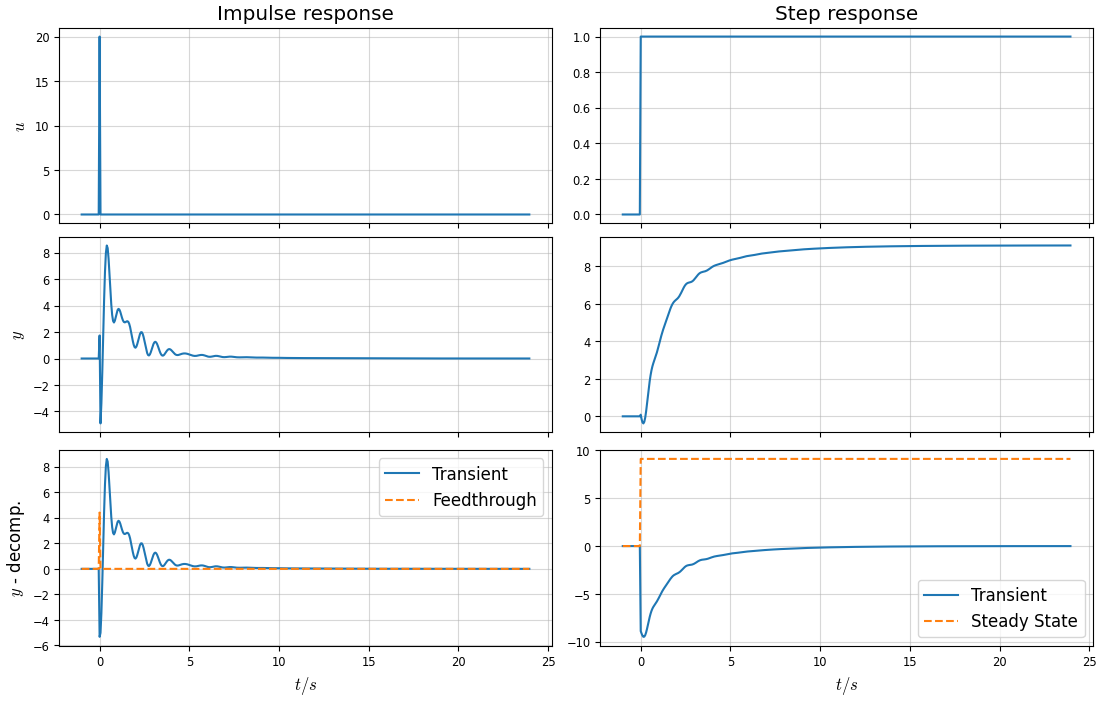

In [60]:
sys = cm.rss(20)
sys.D = [rng.rand()]

N = 500
h = 0.05
T = np.arange(N)*h - 1.0

fig, ax = plt.subplots(3,2, sharex=True, figsize=[11, 7])

## impulse response
impIn = np.zeros([1,N])
impIn[:,np.argmin(abs(T))] = 1.0/h

impResponse = cm.forced_response(sys, T=T, U=impIn)

_ = ax[0,0].set(title="Impulse response", ylabel="$u$")
_ = ax[0,0].plot(impResponse.time, impResponse.inputs)
_ = ax[1,0].set(ylabel="$y$")
_ = ax[1,0].plot(impResponse.time, impResponse.outputs)

impTrans = np.full(len(T), np.nan)
tidx = 0
for t in T:
    impTrans[tidx] = sys.C@sclin.expm(sys.A*t)@sys.B
    tidx+=1
impTrans[T<0] = 0.0
l1, = ax[2,0].plot(T, impTrans, label="Transient")
l2, = ax[2,0].plot(T, np.squeeze(sys.D*impIn), '--', label="Feedthrough")
_ = ax[2,0].set(xlabel="$t/s$", ylabel="$y$ - decomp.")
_ = ax[2,0].legend(handles=[l1,l2])

## step response
stpIn = np.zeros([1,N])
stpIn[:,T>=0.0] = 1.0

stpResponse = cm.forced_response(sys, T=T, U=stpIn)

_ = ax[0,1].set(title="Step response")
_ = ax[0,1].plot(stpResponse.time, stpResponse.inputs)
_ = ax[1,1].plot(stpResponse.time, stpResponse.outputs)

stpTrans = np.full(len(T), np.nan)
tidx = 0
for t in T:
    stpTrans[tidx] = sys.C@lin.inv(sys.A)@sclin.expm(sys.A*t)@sys.B
    tidx+=1
stpTrans[T<0] = 0.0
stpStead = np.full(len(T),np.squeeze(sys.D - sys.C@lin.inv(sys.A)@sys.B))
stpStead[T<0] = 0.0
l1, = ax[2,1].plot(T, stpTrans, label="Transient")
l2, = ax[2,1].plot(T, stpStead, '--', label="Steady State")
_ = ax[2,1].set(xlabel="$t / s$")
_ = ax[2,1].legend(handles=[l1,l2])

Decomposing a signal into a transient and steady state part? How is that possible? It really comes down to seperating the time dependent and time independent parts. By convolution of the input, we can express the state and output trajectory of any LTI system as $$ x(t) = e^{At}x_0 + \int_0^t e^{A(t-\tau)}Bu(\tau)d\tau$$ 
and $$ y(t) = Cx(t) + Du(t) = Ce^{At}x_0 + \int_0^t Ce^{A(t-\tau)}Bu(\tau)d\tau + Du(t).$$
Here, the first term is the effect of the initial condition, the second term is influenced by the input and the third term is the direct feedthrough. 

Now assuming $x_0 =0$, and substituting the respective input time-signals yields the solutions $$ y_\text{impulse}(t) = \underbrace{Ce^{At}B}_\text{Transient} + \underbrace{D\delta(t)}_\text{Feedthrough}$$
and $$ y_\text{step}(t) = \underbrace{CA^{-1}e^{At}B}_\text{Transient} + \underbrace{D - CA^{-1}B}_\text{Steady State}.$$
Tada, we've decomposed the signal!

## Reachability
This output trajectory expression answers some interesting questions too: what states are we able to control the system to? This is called the reachability of the system! Remember we have equilibria $(\bar x, \bar u) \leftarrow A\bar x + B\bar u = 0$? Well then if $A$ is invertible this means that $\bar x = -A^{-1}B\bar u$. So, if $A^{-1}B$ is full rank, we can attain any steady state we'd desire!

This only answers steady state reachability, what can we reach in transient manners though? That's slightly more involved, but not too bad. Lets look back at the expression $$ x(t) = e^{At}x_0 + \int_0^t e^{A(t-\tau)}Bu(\tau)d\tau,$$ 
then the interesting part is $\int_0^t e^{A(t-\tau)}Bu(\tau)d\tau = \int_0^t e^{At}Bu(t-\tau)d\tau$ and especially $e^{At}B$, because this factor we can't influence with the input. The term with the initial condition can be compensated for anyways.

### Cayley–Hamilton theorem
Our bestest buddies Cayley and Hamilton came up with a theorem that we need to understand the factor $e^{At}$ better. Quick reminder of how Taylor series  worked (around 0 specifically (also called MacLaurin series if you want to do some barefaced fame stealing)): $$ f(x) = \sum_{k=0}^{\infty}\frac{f^{(k)}(0)}{k!}x^k = \sum_{k=0}^{\infty}\alpha_k(x) f^{(k)}(0).$$
Also remember how exponential derivatives worked: $$e^{At} \overset{d/dt}{\rightarrow} Ae^{At} \overset{d/dt}{\rightarrow} A^2e^{At} \overset{d/dt}{\rightarrow} A^3e^{At} \overset{d/dt}{\rightarrow} ... \Rightarrow \frac{d^k}{d^kt}e^{At} = A^ke^{At}.$$

Looks like we're getting somewhere, what if we substitute that derivative expression into the **Taylor** series and recall that $e^{0A}=I$, then $$ e^{At} = \sum_{k=0}^{\infty}\alpha_k(x) A^k.$$
One step closer still! Now lets right multiply with $B$ and write the summation as a matrix multiplication $$ e^{At}B =  \mathbf{\alpha}(t)\begin{bmatrix}B & AB & A^2B & A^3B & \cdots \end{bmatrix}, \qquad \alpha_k(t)=\frac{t^k}{k!}.$$

So if $\begin{bmatrix}B & AB & A^2B & A^3B & \cdots \end{bmatrix}$ has full row rank, we can use the input to make $\int_0^t e^{A(t-\tau)}Bu(\tau)d\tau$ anything we want, so we can make $x(t)$ anything we want!! This is the reachability criterion and we actually only have to check the first $n-1$ powers of $A$. This forms the so called reachability matrix (also called controllability matrix), $$ W_r = \begin{bmatrix}B & AB & A^2B & A^3B & \cdots & A^{n-1}B\end{bmatrix}.$$
So if this $W_r$ of the pair $(A,B)$ is full rank, the system is reachable (or controllable).

There is also a coordinate transform to something called the reachable canonical form. It's in the slides but not very useful in this explanation.

<div style="text-align:center;background-color:tomato;">End of lecture 5</div>

## Feedback control
WOW ARE WE GOING TO DO CONTROL NOW??? *FINALLY*???? Yes! No... There's one more difference we need to explain. There are two types of feedback control, output and state feedback. The difference is in the name and here you also see the difference in a block diagram for a plant/process/system, $P$, and a controller, $C$.

![output vs state feedback](xyFB.svg)

Output feedback is stuff like PID, or in other terms: disgusting. We'll look at state feedback now! *The real stuff.*

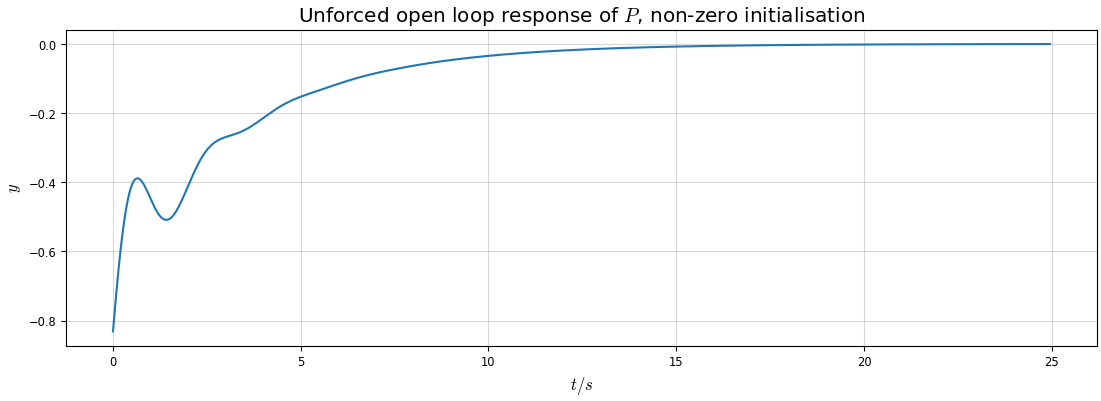

In [61]:
Ppoles, Pzeros = [-.3, -1+3j, -1-3j], [-3]
P = cm.ss(cm.zpk(zeros=Pzeros, poles=Ppoles, gain=1, dt=0))
nx = len(P.poles())
x0 = rng.randn(nx,1)

T = np.arange(500)*0.05
unforced = cm.forced_response(sysdata=P, T=T, X0=x0)

fig, ax = plt.subplots()
ax.plot(unforced.time, unforced.outputs)
_ = ax.set(title="Unforced open loop response of $P$, non-zero initialisation", xlabel="$t/s$", ylabel="$y$")


In [62]:
## Check controllability!
Wr = cm.ctrb(P.A, P.B)

if lin.matrix_rank(Wr) < nx:
    raise "System is uncontrollable ):"
else:
    print("System is controllable :)")

System is controllable :)




We can choose the controller $C: u = -Kx$, and for reachable systems, we can always find a $K$ such that the closed loop system has poles at freely chosen locations. What does that closed loop system look like? Substituting the controller into the state dynamics yields
$$ \dot x = Ax + Bu = Ax - BKx = (A-BK) x.$$
So the closed loop system poles are the eigenvalues of $(A-BK)$. If we choose the poles to have a negative real part, the closed loop is stable and the output will go to zero. This type of controller that steers to zero is called a regulator.

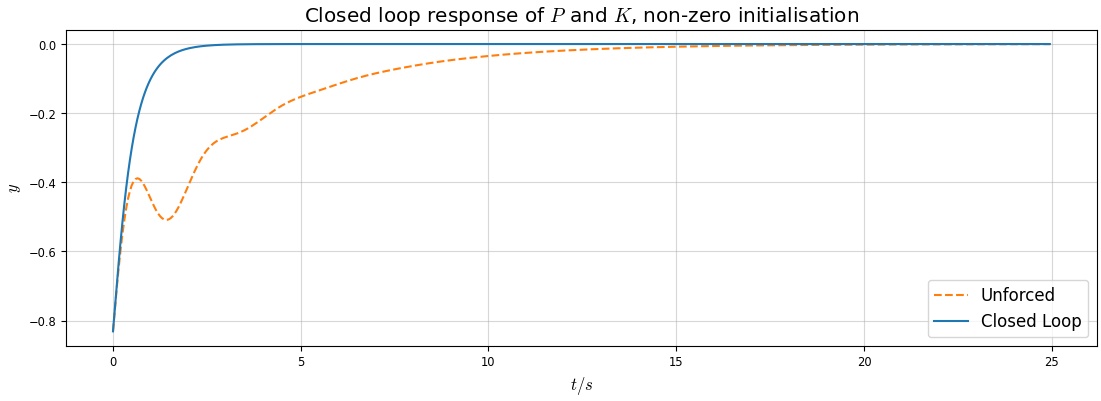

In [63]:
CLpoles = np.linspace(-2, -6, nx)
K = cm.place(P.A, P.B, CLpoles)
CL = cm.ss(P.A-P.B@K, np.zeros([nx,1]), P.C, P.D)

forced = cm.forced_response(sysdata=CL, T=T, X0=x0)

fig, ax = plt.subplots()
ax.plot(unforced.time, unforced.outputs, '--', color="tab:orange", label="Unforced")
ax.plot(forced.time, forced.outputs, color="tab:blue", label="Closed Loop")
ax.legend()
_ = ax.set(title="Closed loop response of $P$ and $K$, non-zero initialisation", xlabel="$t/s$", ylabel="$y$")


However, regulating to zero is boring, I want to be able to tell my system to do a backflip! We need to add a reference, and I'll spoil that we also need a reference gain $k_f$:

![Reference tracking](refTrackCL.svg)

So how does this work then... Same substitution as before!
$$ \dot x = Ax + Bu = Ax + B(k_f r - Kx) = (A-BK) x + Bk_f r.$$
Now to determine $k_f$, we want to prevent steady state errors, so $\bar y = r$. Steady state also means
$$ \dot x = 0 = (A-BK) \bar x + Bk_f r \rightarrow \bar x = -(A-BK)^{-1}Bk_f r.$$
Now assuming $D=0$ to make things easier, substituting and rewriting gives
$$\bar y = r \rightarrow C\bar x + \underbrace{D}_{=0}\bar u = C\bar x = r$$
$$\rightarrow -C(A-BK)^{-1}Bk_f r = r \rightarrow k_f = \frac{-1}{C(A-BK)^{-1}B}.$$


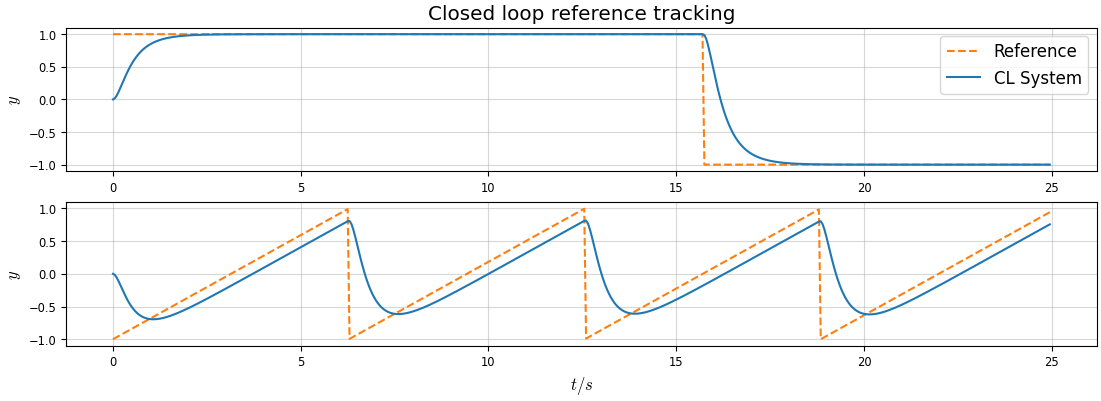

In [64]:
kf = (-1/(P.C@lin.inv(P.A - P.B@K)@P.B))[0,0]

CLref = cm.ss(P.A-P.B@K, P.B*kf, P.C, P.D)
REFsqr = signal.square(t=T*0.2)
REFsaw = signal.sawtooth(t=T)

reftrack_sqr = cm.forced_response(sysdata=CLref, T=T, U=REFsqr)
reftrack_saw = cm.forced_response(sysdata=CLref, T=T, U=REFsaw)

fig, ax = plt.subplots(2,1)
ax[0].plot(T, REFsqr, '--', color="tab:orange", label="Reference")
ax[0].plot(reftrack_sqr.time, reftrack_sqr.outputs, color="tab:blue", label="CL System")
ax[1].plot(T, REFsaw, '--', color="tab:orange", label="Reference")
ax[1].plot(reftrack_saw.time, reftrack_saw.outputs, color="tab:blue", label="CL System")
ax[0].legend()
_ = ax[0].set(title="Closed loop reference tracking", ylabel="$y$")
_ = ax[1].set(xlabel="$t/s$", ylabel="$y$")


## Integral action
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*The theory of everything is not found yet, so our model **always** sucks*

Most likely the model we have is not a perfect representation of the real world. "Neglect air friction, neglect static/dynamic friction and hysteresis, assume rigid bodies, assume perfect efficiency, ..." All lies we tell ourselves to make our lives easier and to blind ourselves to the harsh reality.

So if out model is incorrect, what does that mean for our controller? Simply said, it's not exactly what we want, but *it's close*. To get it perfect however, we need to add an output feedback part to our state feedback controller. An integrator of the reference-output-error to be precise. This integrator wil drive the integral of the error, $z$, to zero, meaning that the error will be zero. I'll stop talking now and show the block diagram so you actually understand.

![Integral action](IntActCL.svg)

Sooooo maths time. Substitute everything into everything, yada yada, this is largely what control engineers do. Also assume D=0. Lets start with plant equations and work our way backwards through the block diagram.

$$\left\{\begin{aligned}\dot x &= Ax + Bu = Ax + B(k_fr-Kx-k_iz) = (A-BK)x + Bk_fr-Bk_iz \\ y &= Cx\end{aligned}\right.$$
and
$$\dot z = y - r = Cx - r.$$
Augmenting (stacking) the $x$ and $z$ dynamics gives the nice expression
$$\left\{\begin{aligned}\begin{bmatrix}\dot x\\\dot z\end{bmatrix} &= \begin{bmatrix}
(A-BK) & -Bk_i\\ C&0\end{bmatrix}\begin{bmatrix} x\\ z\end{bmatrix} + \begin{bmatrix}Bk_f\\-1\end{bmatrix}r \\ y &= \begin{bmatrix}C&0\end{bmatrix}\begin{bmatrix} x\\ z\end{bmatrix}.\end{aligned}\right.$$
Saying $q = \begin{bmatrix} x\\ z\end{bmatrix}$ gives the new state space representation
$$\left\{\begin{aligned}\dot q &= \begin{bmatrix}
(A-BK) & -Bk_i\\ C&0\end{bmatrix}q + \begin{bmatrix}Bk_f\\-1\end{bmatrix}r \\ y &= \begin{bmatrix}C&0\end{bmatrix}q.\end{aligned}\right.$$

Note that the integral error is independent from $A$, so however bad our modeling mistakes are, the integral action will fix it (as long as it's stable). First however, lets look at the nominal behaviour.

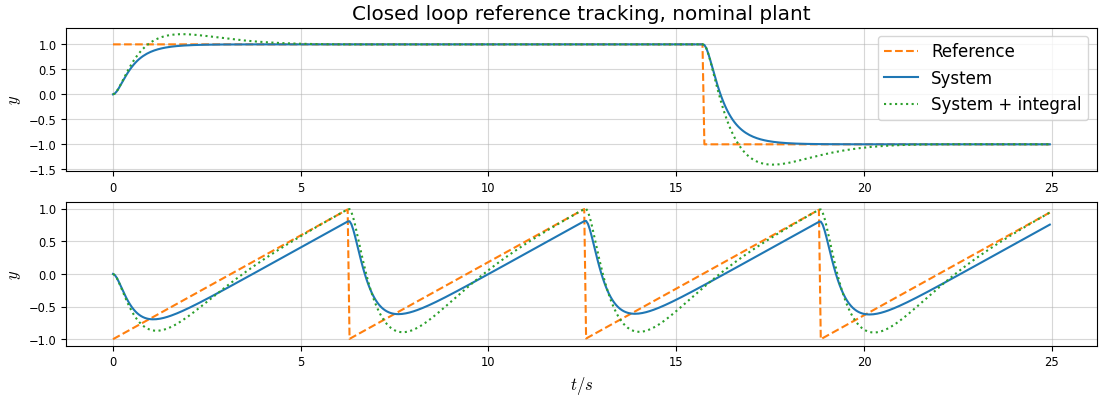

In [65]:
ki = 10

Ai = np.block([[P.A-P.B@K, -P.B*ki],[P.C, np.zeros([P.C.shape[0], P.B.shape[1]])]])
Bi = np.vstack((P.B*kf, -1))
Ci = np.hstack((P.C, [[0]]))
CLint = cm.ss(Ai, Bi, Ci, np.zeros([1,1]))

reftrackint_sqr = cm.forced_response(sysdata=CLint, T=T, U=REFsqr)
reftrackint_saw = cm.forced_response(sysdata=CLint, T=T, U=REFsaw)

fig, ax = plt.subplots(2,1)
ax[0].plot(T, REFsqr, '--', color="tab:orange", label="Reference")
ax[0].plot(reftrack_sqr.time, reftrack_sqr.outputs, color="tab:blue", label="System")
ax[0].plot(reftrackint_sqr.time, reftrackint_sqr.outputs, ':', color="tab:green", label="System + integral")
ax[1].plot(T, REFsaw, '--', color="tab:orange", label="Reference")
ax[1].plot(reftrack_saw.time, reftrack_saw.outputs, color="tab:blue", label="System")
ax[1].plot(reftrackint_saw.time, reftrackint_saw.outputs, ':', color="tab:green", label="System + integral")
ax[0].legend()
_ = ax[0].set(title="Closed loop reference tracking, nominal plant", ylabel="$y$")
_ = ax[1].set(xlabel="$t/s$", ylabel="$y$")

And now we face dreadful reality and perturb our plant a little!

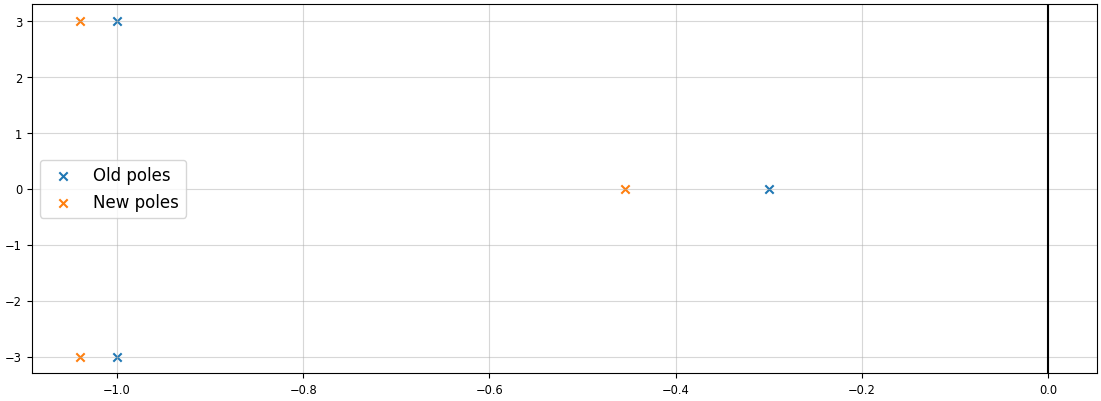

In [66]:
fig, ax = plt.subplots(1, 1)
ax.axvline(color='k')
s1 = ax.scatter(np.real(P.poles()), np.imag(P.poles()), marker='x', color='tab:blue', label="Old poles")

idx = 0
while idx < nx:
    scramble = abs(float(1.+rng.randn()))
    if idx == nx-1: # last pole
        Ppoles[idx] = Ppoles[idx].real * scramble + Ppoles[idx].imag*1j
        idx += 1
    elif Ppoles[idx] == (Ppoles[idx+1].real - Ppoles[idx+1].imag*1j): # Complex pole pair
        Ppoles[idx] = Ppoles[idx].real * scramble + Ppoles[idx].imag*1j
        Ppoles[idx+1] = Ppoles[idx].real - Ppoles[idx].imag*1j
        idx += 2
    else: # Real pole
        Ppoles[idx] = Ppoles[idx] * float(1.+rng.randn())
        idx += 1
        

P = cm.ss(cm.zpk(zeros=Pzeros, poles=Ppoles, gain=1, dt=0))
s2 = ax.scatter(np.real(P.poles()), np.imag(P.poles()), marker='x', color='tab:orange', label="New poles")
ax.legend(handles=[s1,s2])



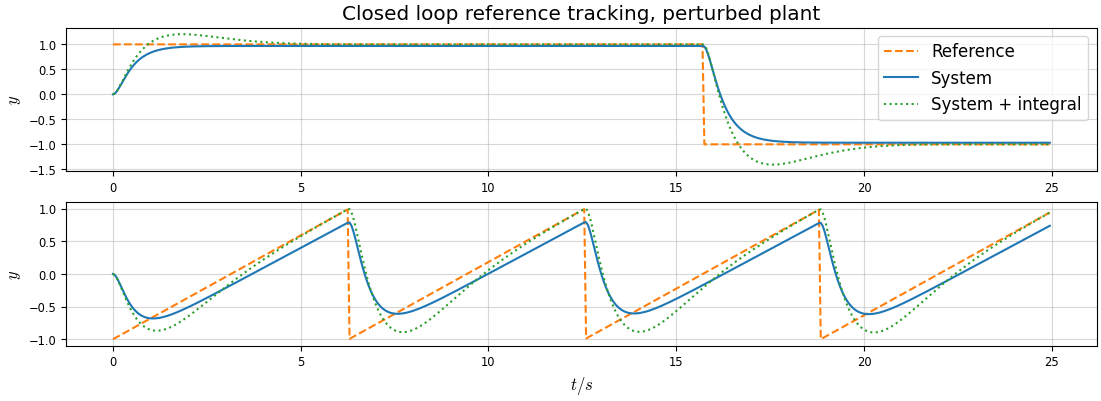

In [67]:

CLref_p = cm.ss(P.A-P.B@K, P.B*kf, P.C, P.D)

reftrack_sqr_p = cm.forced_response(sysdata=CLref_p, T=T, U=REFsqr)
reftrack_saw_p = cm.forced_response(sysdata=CLref_p, T=T, U=REFsaw)

Ai_p = np.block([[P.A-P.B@K, -P.B*ki],[P.C, np.zeros([P.C.shape[0], P.B.shape[1]])]])
Bi_p = np.vstack((P.B*kf, -1))
Ci_p = np.hstack((P.C, [[0]]))
CLint_p = cm.ss(Ai, Bi, Ci, np.zeros([1,1]))

reftrackint_sqr_p = cm.forced_response(sysdata=CLint_p, T=T, U=REFsqr)
reftrackint_saw_p = cm.forced_response(sysdata=CLint_p, T=T, U=REFsaw)

fig, ax = plt.subplots(2,1)
ax[0].plot(T, REFsqr, '--', color="tab:orange", label="Reference")
ax[0].plot(reftrack_sqr_p.time, reftrack_sqr_p.outputs, color="tab:blue", label="System")
ax[0].plot(reftrackint_sqr_p.time, reftrackint_sqr_p.outputs, ':', color="tab:green", label="System + integral")
ax[1].plot(T, REFsaw, '--', color="tab:orange", label="Reference")
ax[1].plot(reftrack_saw_p.time, reftrack_saw_p.outputs, color="tab:blue", label="System")
ax[1].plot(reftrackint_saw_p.time, reftrackint_saw_p.outputs, ':', color="tab:green", label="System + integral")
ax[0].legend()
_ = ax[0].set(title="Closed loop reference tracking, perturbed plant", ylabel="$y$")
_ = ax[1].set(xlabel="$t/s$", ylabel="$y$")


See how bad the system without the integral action performs?

<div style="text-align:center;background-color:tomato;">End of lecture 6</div>

## Controller design is an art
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Art with maths is the best kind of art.*

Okay, we know now what structure our controller will have. Time to design our controller! Since we do this by placing the poles of the closed loop systems via $K$, we'll look at what behaviour various poles show. Poles come in conjugate pairs, so for generality we'll look at the second-order ODE
$$ \ddot q + 2\zeta\omega_0\dot q + \omega_0^2 = k\omega_0^2 u.$$
Here, $\omega_0$ is called the natural frequency and $\zeta$ the damping ratio. Then, the characteristic polynomial is
$$s^2 + 2\zeta\omega_0s + \omega_0^2,$$
with roots/poles at $\lambda = -\zeta\omega_0\pm\omega_0\sqrt{\zeta^2-1}$. Time to play around again!

$\lambda_1 = -\zeta\omega_0+\omega_0\sqrt{\zeta^2-1} = -1.040+0.780j$

$|\lambda_1| = \omega_0 = 1.300$

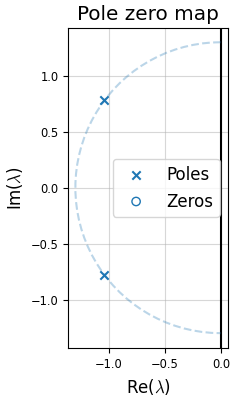

In [68]:
omega0 = 1.3
zeta = .8

### Processing and Plotting ###
s = cm.tf('s')
P1 = 1/(s**2 + 2*zeta*omega0*s + omega0**2)

fig, ax = plt.subplots()
ax.axvline(color='k')
s1 = ax.scatter(np.real(P1.poles()), np.imag(P1.poles()), marker='x', color='tab:blue', label="Poles")
s2 = ax.scatter(np.real(P1.zeros()), np.imag(P1.zeros()), marker='o', facecolors='none', color='tab:blue', label="Zeros")
ax.plot(np.real(omega0*np.exp(np.linspace(0.5,1.5)*np.pi*1j)), np.imag(omega0*np.exp(np.linspace(0.5,1.5)*np.pi*1j)), '--', alpha=.3)
ax.set(title="Pole zero map", xlabel="Re($\lambda$)", ylabel="Im($\lambda$)", aspect='equal')
ax.legend(handles=[s1, s2])

display(Markdown(rf'$\lambda_1 = -\zeta\omega_0+\omega_0\sqrt{"{"}\zeta^2-1{"}"} = {-zeta*omega0 + omega0*np.emath.sqrt(zeta**2-1):.3f}$'))
display(Markdown(rf'$|\lambda_1| = \omega_0 = {np.abs(P1.poles()[0]):.3f}$'))

Now lets look at the step responses! We have three (or four) terms for intervals of $\zeta$:
1. $\zeta>1$ is overdamped
2. $\zeta=1$ is critically damped
3. $\zeta\in [0,1]$ is underdamped
4. and $\zeta<1$ is unstable.

Also the speed of the response is defined by $\omega_0$. We'll plot a few of these.

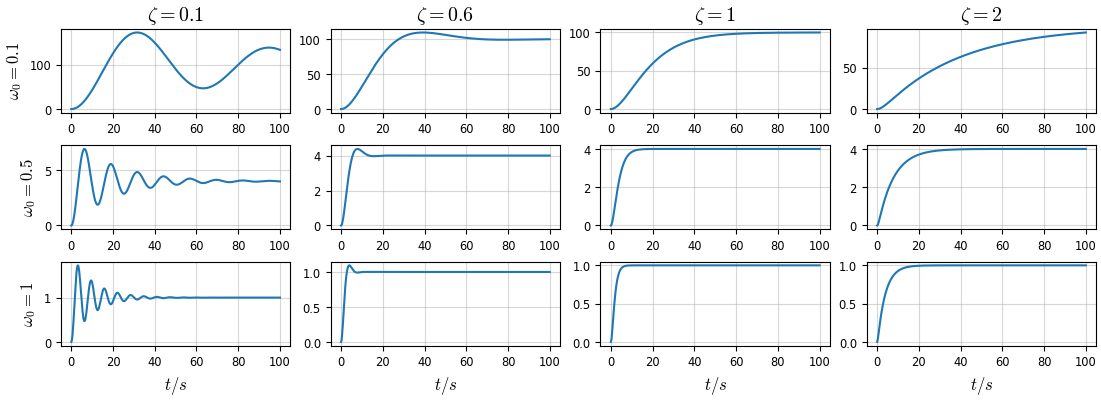

In [69]:
# You can put in whatever and any number of values you want
Omega0 = [.1, .5, 1]
Zeta = [0.1, 0.6, 1, 2]

### Processing and Plotting ###
fig, ax = plt.subplots(len(Omega0), len(Zeta))
axIdx1, axIdx2 = 0 , 0
T = np.linspace(0, 100, 500)

for omega0 in Omega0:
    for zeta in Zeta:
        Pq = cm.ss(1/(s**2 + 2*zeta*omega0*s + omega0**2), dt=0)
        response = cm.forced_response(Pq, T=T, U=np.ones([1, len(T)]))
        ax[axIdx1, axIdx2].plot(response.time, response.outputs)
        axIdx2 += 1
    axIdx1 += 1
    axIdx2 = 0

[ax[0,p].set(title=f"$\zeta={Zeta[p]}$") for p in range(len(Zeta))]
[ax[p,0].set(ylabel=f"$\omega_0={Omega0[p]}$") for p in range(len(Omega0))]
_ = [ax[2,p].set(xlabel=f"$t/s$") for p in range(len(Zeta))]

### Why are second order systems so important?
It turns out that system behaviour is largely dictated by the dominant eigenvalue pair (equivalently, the slowest pair, the pair with the largest real value). If there are pole pairs with the same real value, the pair with the lowest damping ratio $\zeta = -\frac{\mathfrak{R}(\lambda)}{|\lambda|}$ is the dominant pair.


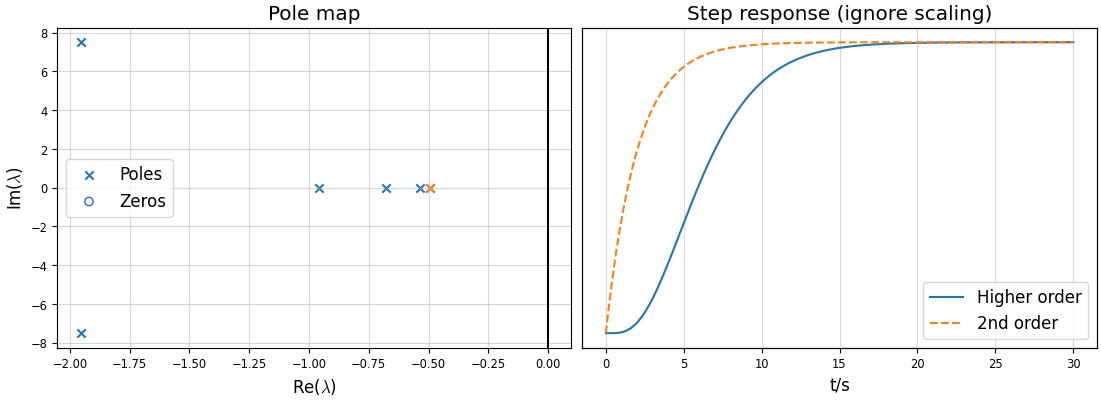

In [70]:
if True:
    P2 = cm.rss(6)
    P2 = cm.ss(cm.zpk(poles=P2.poles(), zeros=[], gain=1, dt=0))
else:
    P2 = cm.ss(cm.zpk(poles=[-.1+1j, -.1-1j, -1], zeros=[], gain=1, dt=0))

# Find dominant poles
poles = P2.poles()
DomRe = max(np.real(poles))
DomPoles = poles[np.abs(np.real(poles) / DomRe -1) < 1e-2]

if len(DomPoles) > 2:
    dampRatio = -np.real(DomPoles)/np.abs(DomPoles)
    DomPoles2d = DomPoles[dampRatio == min(dampRatio)]
else:
    DomPoles2d = DomPoles

P2b = cm.ss(cm.zpk(poles=DomPoles, zeros=[], gain=1, dt=0))
P2d = cm.ss(cm.zpk(poles=DomPoles2d, zeros=[], gain=1, dt=0))

T = np.linspace(0, 30, 500)
response =   cm.forced_response(P2,  T=T, U=np.ones([1, len(T)]))
response2b = cm.forced_response(P2b, T=T, U=np.ones([1, len(T)]))
response2d = cm.forced_response(P2d, T=T, U=np.ones([1, len(T)]))

fig, ax = plt.subplots(1, 2)
ax[0].axvline(color='k')
s1 = ax[0].scatter(np.real(P2.poles()), np.imag(P2.poles()), marker='x', color='tab:blue', label="Poles")
if len(DomPoles) > 2: s2 = ax[0].scatter(np.real(P2b.poles()), np.imag(P2b.poles()), marker='x', color='tab:brown', label="Additional pole")
ax[0].scatter(np.real(P2d.poles()), np.imag(P2d.poles()), marker='x', color='tab:orange')
ax[0].set(title="Pole map", xlabel="Re($\lambda$)", ylabel="Im($\lambda$)")
ax[0].legend(handles=[s1, s2])

ax1b = ax[1].twinx()
l1, = ax[1].plot(response.time, response.outputs, color="tab:blue", label="Higher order")
l2, = ax1b.plot(response2d.time, response2d.outputs, '--', color="tab:orange", label="2nd order")
ax1b.set_yticks([])
if len(DomPoles) > 2:
    ax1c = ax1b.twinx()
    ax1c.set_yticks([])
    l3, = ax1c.plot(response2b.time, response2b.outputs, '--', color="tab:brown", label="Reduced order")
ax[1].set(title="Step response (ignore scaling)", xlabel="t/s", yticks=[])
if len(DomPoles) > 2: ax[1].legend(handles=[l1, l2, l3])
else: ax[1].legend(handles=[l1, l2])

## Art is for suckers and should be optimised
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*If you believe AI artists are artist, you're wrong, but you'll like this part.*

Linear Quadratic Regulators (LQR) have a special place in my heart. Instead of having a (in some sense) heuristic $K$, smarter people than me came up with the idea of expressing $K$ as the solution to an optimisation problem to obtain *optimal control*. So what optimisation is this? The trick is to balance the control input action and the state deviation, so that calls for the input optimisation $$\min_u \int_0^\infty x^\intercal (t) Q_x x(t) + u^\intercal(t) Q_u u(t) dt.$$ 

The $Q$ matrices here are semi-positive weighing matrices, the higher the weight, the more penalised the signal.

The solution to this equation is not easy, but it's found by finding symmetric $S\in\mathbb{R}^{n\times n}, S>0$ such that
$$A^\intercal S + SA - SBQ^{-1}_uB^\intercal S + Q_x = 0,$$
which is called the Algebraic Riccati Equation (ARE). Then with this $S$ we can find $K=Q^{-1}_uB^\intercal S$. Also $u=-Kx$, as a reminder. Lets see if you can beat the optimal control!

System is controllable :)


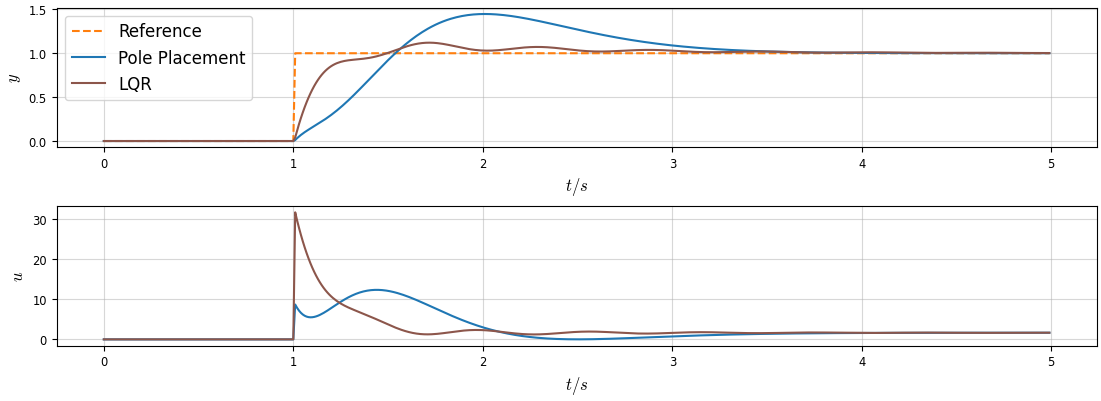

In [71]:
P3 = cm.rss(4)
P3.D = 0
nx = len(P3.poles())
x0 = rng.randn(nx,1)

T = np.arange(500)*0.01
REFstep = np.zeros(T.shape)
REFstep[T>1] = 1

## Check controllability!
Wr = cm.ctrb(P3.A, P3.B)
if lin.matrix_rank(Wr) < nx:
    raise Exception( "System is uncontrollable ):")
else:
    print("System is controllable :)")

## Pole Placement
CLpoles = [-3+1j, -3-1j, -4-2j, -4+2j] ### CHANGEME

Kpp = cm.place(P3.A, P3.B, CLpoles)
kfpp = (-1/(P3.C@lin.inv(P3.A - P3.B@Kpp)@P3.B))[0,0]
CLpp = cm.ss(P3.A-P3.B@Kpp, P3.B*kfpp, P3.C, P3.D)
poleplac = cm.forced_response(sysdata=CLpp, T=T, U=REFstep)

## LQR
Qx, Qu = np.eye(nx)*1e2, np.eye(1)*1 ### CHANGEME

Klqr, S, E = cm.lqr(P3.A, P3.B, Qx, Qu) 
kflqr = (-1/(P3.C@lin.inv(P3.A - P3.B@Klqr)@P3.B))[0,0]
CLlqr = cm.ss(P3.A-P3.B@Klqr, P3.B*kflqr, P3.C, P3.D)
lqrRes = cm.forced_response(sysdata=CLlqr, T=T, U=REFstep)

fig, ax = plt.subplots(2,1)
ax[0].plot(T, REFstep, '--', color="tab:orange", label="Reference")
ax[0].plot(poleplac.time, poleplac.outputs, color="tab:blue", label="Pole Placement")
ax[0].plot(lqrRes.time, lqrRes.outputs, color="tab:brown", label="LQR")
ax[0].legend()
ax[0].set(ylabel="$y$", xlabel="$t/s$")

ax[1].plot(poleplac.time, (-Kpp@poleplac.states)[0,:] + kfpp*REFstep, color="tab:blue", label="Pole Placement")
ax[1].plot(lqrRes.time, (-Klqr@lqrRes.states)[0,:] + kflqr*REFstep, color="tab:brown", label="LQR")
_=ax[1].set(ylabel="$u$", xlabel="$t/s$")

<div style="text-align:center;background-color:tomato;">End of lecture 7</div>

## Observe this
Reality is here to ruin our day again. Practically, we never know/measure the full state, so $u=-Kx$ doesn't really work, because we don't know $x$. That means everything that we've done up to now only exists in the realms of mathematics. But our trickery is endless! We'll say that we have an **estimate** of the state, $\hat x$. We'll also say that we have an estimation error $\tilde x = x - \hat x$. Lastly, we make a *Luenberger observer*
$$\dot{\hat x} = A\hat x + B u + L(y − C \hat x).$$
Now it's that time again, our favourite time, substitution time!
$$\dot{\hat x} = A\hat x + B u + L(y − C \hat x) = A\hat x + B u + LC(x − \hat x) = A\hat x + B u + LC\tilde x$$
$$\Rightarrow \dot x - \dot{\hat x} = \dot{\tilde x} = Ax + Bu - A\hat x - B u - LC\tilde x = A(x − \hat x) - LC\tilde x = A\tilde x - LC\tilde x = (A-LC)\tilde x.$$

Wait, that's familiar! That looks a whole lot like controller pole placement! That is because there is a duality between Luenberger observers and state feedback controllers, practically anything you can do for controllers/controlability with the pair $(A,B)$, you can do for observers/observability with the pair $(A^\intercal, C^\intercal)$. So we have
| Control   | Observe   |
| --------- | --------- |
| $K = \texttt{cm.place}(A, B, p)$      | $L.T = \texttt{cm.place}(A.T, C.T, p)$       |
| $W_r = \begin{bmatrix}B & AB & \cdots & A^{n-1}B\end{bmatrix}$ | $W_o^\intercal = \begin{bmatrix}C^\intercal & (CA)^\intercal & \cdots & (CA^{n-1})^\intercal\end{bmatrix}$ |

So what does this do in practise? Lets look at the estimation error for some fun inputs.


<div style="text-align:center;background-color:tomato;">End of lecture 8</div>

<div style="text-align:center;background-color:tomato;">End of lecture "Transfer Functions"</div>

<div style="text-align:center;background-color:tomato;">End of lecture "Bode Plots"</div>

Put in the Nyquist explaination here (now at the end of the document)
<div style="text-align:center;background-color:tomato;">End of lecture "Frequency Domain Analysis"</div>

<div style="text-align:center;background-color:tomato;">End of lecture "PID control"</div>

<div style="text-align:center;background-color:tomato;">End of lecture "Frequency Domain Design I & II"</div>

---

## Introduction to the Nyquist Criterion

This exploration will be top-down, so we'll start with the definition and work our way down to the nitty gritty of why and how the criterion works.

### Definition
Wikipedia gives this definition of the criterion:

>Given a Nyquist contour $\Gamma_s$, let $P$ be the number of poles of $L(s)$ encircled by $\Gamma_s$, and $Z$ be the number of zeros of $1+L(s)$ encircled by $\Gamma_s$. Alternatively, and more importantly, if $Z$ is the number of poles of the closed loop system in the right half plane, and $P$ is the number of poles of the open-loop transfer function $L(s)$ in the right half plane, the resultant contour in the $L(s)$-plane, $\Gamma_{L(s)}$, shall encircle (clockwise) the point $(-1+j0)$ $N$ times such that $N = Z - P$.

That's pretty overwhelming! Let's take it apart:
- Nyquist contour $\Gamma_s$: this is defined as the clockwise contour encompassing the Right Half of the imaginary Plane (RHP). It is also the collection of all $s$ we'll consider.
- $L(s)$: the loop transfer function; the product of the plant/process and controller transfer functions.
- $P$: the number of RHP poles of $L(s)$.
- $Z$: the number of RHP zeros of $1+L(s)$ **and** the number of RHP poles of the closed loop system.
- $N$: the number of clockwise rotations around $-1+j0$ of $L(\Gamma_s)$, and $N=Z-P$.

### Stability
So $Z$ is supposedly the number of unstable poles of the closed loop system. Then if $Z=0$, there are no RHP poles destabilizing the closed loop, so the closed loop is stable! Now we also got that $N=Z-P\rightarrow Z=N+P$, so we can just count the clockwise encirclements in the Nyquist plot $L(\Gamma_s)$ and add it to the number of RHP poles of $L(s)$ and if that's zero the closed loop is stable! Wait but something added to something should be zero? Good question, $N$ is positive for clockwise encirclements, but negative for counterclockwise encirclements. So, alternatively, we can say the closed loop is stable if (and only if) the **net** number of counterclockwise encirclements of $-1+j0$ is equal to the number of RHP poles of $L(s)$. This is our main use for the Nyquist criterion, because this is how we assess stability.

### Where do they get these transfer functions from?
Another excellent question! This is where it gets a tad more difficult, but we'll soon look at some pictures too. First, we have a quick look at the closed loop transfer function again. Our block diagram with reference $r$, output error $e$, actuation $u$, output $y$, controller $C$, and process $G$ is 

![](CLsys.svg)

Then in the frequency domain the transfer from the reference to the output is $\frac{Y(s)}{R(s)}$. We get this by following the chain as 
$$Y(s) = G(s)U(s) = G(s)C(s)E(s) = L(s)E(s) = L(s)(R(s)-Y(s))$$
$$\rightarrow (1+L(s))Y(s) = L(s)R(s) \rightarrow \frac{Y(s)}{R(s)} = \frac{L(s)}{1+L(s)}.$$

So we can conclude that zeros of $1+L(s)$ are poles of our closed loop system. We saw $1+L(s)$ before! *And they were talking about its zeros!!* In the Nyquist criterion, $Z$ was defined as "the number of zeros of $1+L(s)$ encircled by $\Gamma_s$" **and** "the number of poles of the closed loop system in the right half plane." We've now discovered why these are linked!

### Why encirclements then?
This is where we start letting go of formal mathematics and start going more by visuals. If you're cool however, you can find out more about the formalities in [Cauchy's argument principle](https://en.wikipedia.org/wiki/Argument_principle). It'll take a couple of steps to arrive at the source of the encirclements, but no worries. We'll go through it step by step. 

### First the contour
We'll not go for the full Nyquist contour $\Gamma_s$ immediately, but first take a smaller contour $\Gamma$. Lets define that!

In [72]:
import scipy.interpolate as interp

def Gamma(Q, R):
    # Q in [0, 1], contour coordinate
    # R >0, radius of semicircle contour
    contourLength = 2*R + np.pi*R**2 /2 # diameter + halfcircle
    corner = R / contourLength # the contour coordinate of the corner
    cntr = np.empty_like(Q).astype(complex)
    
    cntr[Q <= corner] = Q[Q <= corner]/corner* R*1j # we're on the positive imaginary axis
    cntr[Q >= 1-corner] = (1-Q[Q >= 1-corner])/corner* R*-1j # we're on the negative imaginary axis
    angMap = interp.interp1d([corner, 1-corner], [np.pi/2, -np.pi/2])
    semcirIdx = (Q>corner) * (Q<1.0-corner) # we're on the semi circle
    cntr[semcirIdx] = R*np.exp(angMap(Q[semcirIdx])*1j)

    return cntr

def drawContour(ax, cntr):## Plot contour
    ax.plot(np.real(cntr), np.imag(cntr), '--', color=[0.1,0.7,0.8])
    ax.set(aspect='equal', ylabel="Im", xlabel="Re")

    ## Plot clockwise arrows
    arrowIdx = np.round(np.linspace(start=0, stop=len(Q), num=6, endpoint=False)).astype(int)

    for idx in range(len(arrowIdx)):
        ax.annotate("", xytext=(np.real(cntr[arrowIdx[idx]]), np.imag(cntr[arrowIdx[idx]])), 
                    xy=(np.real(cntr[arrowIdx[idx]+1]), np.imag(cntr[arrowIdx[idx]+1])),
                    arrowprops=dict(arrowstyle="->"))
    


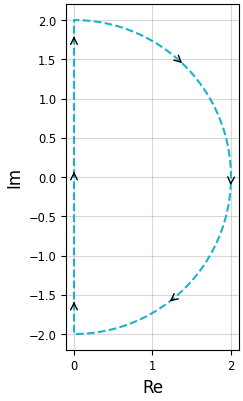

In [73]:
## Create contour
Q = np.linspace(start=0, stop=1, num=150, endpoint=True)
R = 2
cntr = Gamma(Q, R)

fig1, ax = plt.subplots()
drawContour(ax, cntr)

plt.show()

That's a nice semicircle of finite radius! In the end we want to 'walk along the contour' to get its mapping. So we have our complex variable $s$ for our transfer functions and this we'll walk along the contour. That looks like this:

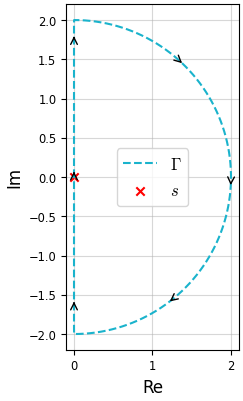

In [74]:
import matplotlib.animation as animation

fig1, ax = plt.subplots()
drawContour(ax, cntr)
sc = ax.scatter([np.real(cntr[0])], [np.imag(cntr[0])], marker='x', color='red')
ax.legend([r'$\Gamma$', r'$s$'])

def animFun(t): 
    sc.set_offsets([np.real(cntr[t]), np.imag(cntr[t])])
    return sc, 
anim = animation.FuncAnimation(fig1, func=animFun, frames=len(Q), interval=30, blit=True)

from IPython.display import HTML
# plt.close(fig1)
# HTML(anim.to_jshtml())

### Shuffling $L(s)$
Next, we will demonstrate the origin of the encirclements. We need to rewrite $L(s)$ a little first though. For a Linear Time Invariant (LTI) system the loop function can be written as a fraction of two polynomials with the respective roots being the zeros and poles of the loop function. Many words, this is it in maths
$$ L(s) = \frac{N_L(s)}{D_L(s)} $$ 
and 
$$ 1+L(s) = \frac{N_L(s) + D_L(s)}{D_L(s)}.$$
From this we can see that $L(s)$ and $1+L(s)$ share the same poles, which are the roots of $D_L(s)$.

Suppose we call $1+L(s) = F(s)$ for now. We are interested in the zeros of $F(s)$, since these are our closed loop poles. Also we know that the sum of two polynomials is another polynomial, so we can write
$$ F(s) = \frac{N_L(s) + D_L(s)}{D_L(s)} = \frac{N_F(s)}{D_F(s)}.$$ 
The roots of $N_F(s)$ are therefore zeros of $F(s)$.

### Polynomials
We'll quickly jump into polynomials for a second. Polynomials are largely defined by their roots. For example, this is what we do when we factorize a parabola formula to find its roots. Similar to that, we can write a polynomial $N_F(s)$ as the product of its $Z$ number of roots, $z_k$, as
$$ N_F(s) = (s - z_1)(s-z_2)...(s-z_Z) = \prod_{k=1}^Z (s - z_k).$$
Then we can also define $N_F^\dagger (s) = \prod_{k=2}^Z (s - z_k)$, such that 
$$N_F(s) = (s-z_1)N_F^\dagger (s).$$

### Inside or outside
Now we're going to make two categories: zeros inside $\Gamma$ and zeros outside $\Gamma$. Let's say $z_1$ lies outside $\Gamma$ and look at the behaviour of *the phase of* $(s-z_1)$ when we walk $s$ along $\Gamma$.

In [75]:
from matplotlib.patches import Arc

def anim_init(z1, ax):
    for i in range(2):
        ax[i].scatter(np.real(z1), np.imag(z1), marker='o', facecolors='none', edgecolors='r', lw=1)
        ax[i].annotate("$z_1$", xy=(np.real(z1), np.imag(z1)),
                    xytext=(.5,.3), textcoords='offset fontsize', color='red')

    ## Animation time! Yeah don't focus too much on this it's fine
    r = cntr - z1
    rm = np.max(np.abs(r))
    ax[1].set(aspect='equal', ylabel="Im", xlabel="Re", xlim=[-rm+np.real(z1), rm+np.real(z1)], ylim=[-rm+np.imag(z1),rm+np.imag(z1)])

    arr = [None,None]
    for i in range(2):
        arr[i] = ax[i].annotate("", xy=(np.real(cntr[0]), np.imag(cntr[0])), 
                    xytext=(np.real(z1), np.imag(z1)),
                    arrowprops=dict(arrowstyle="-|>", color='red'))

    phl1 = plt.plot([np.real(z1),rm/2+np.real(z1)], [np.imag(z1),np.imag(z1)], 'k', lw=1.2, alpha=0.3)
    phl2 = plt.plot([np.real(z1),np.real(z1)+np.real(rm/2*np.exp(1j*np.angle(r[0])))], 
                    [np.imag(z1),np.imag(z1)+np.imag(rm/2*np.exp(1j*np.angle(r[0])))], 'k', lw=1.2, alpha=0.3)
    phArc = Arc((np.real(z1),np.imag(z1)), width=rm/2.3, height=rm/2.3, theta2=np.angle(r[0], deg=True))
    ax[1].add_patch(phArc)

    angr = np.angle(r)
    angr[angr<0] += 2*np.pi
    phlims = np.array([rm/3*np.exp(np.min(angr)*1j), 0j, rm/3*np.exp(np.max(angr)*1j)]) + z1
    phl3 = plt.plot(np.real(phlims), np.imag(phlims), 'b', lw=1.2, alpha=0.3)
    return arr, phArc, phl2, r, rm

def animate(t):
    for i in range(2):
        arr[i].xy = (np.real(cntr[t]), np.imag(cntr[t]))
    phArc.theta2 = np.angle(r[t], deg=True)
    phl2[0].set_data([np.real(z1),np.real(z1)+np.real(rm/2*np.exp(1j*np.angle(r[t])))], 
                    [np.imag(z1),np.imag(z1)+np.imag(rm/2*np.exp(1j*np.angle(r[t])))])
    return arr[0], arr[1], phArc, phl2[0]


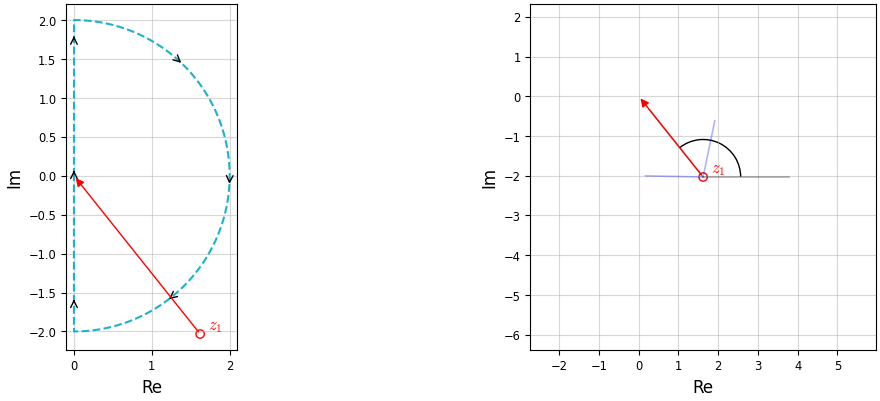

In [76]:

fig2, ax = plt.subplots(1, 2)
drawContour(ax[0], cntr)

## define the zero
z1 = 1.3*R*np.exp(-2/7*np.pi*1j) # You can change me if you'd like

arr, phArc, phl2, r, rm = anim_init(z1, ax)
anim = animation.FuncAnimation(fig2, func=animate, frames=len(Q), interval=50, blit=True)


# plt.close(fig2)
# HTML(anim.to_jshtml())

Okay, that's looking cool! The angle doesn't seem to be changing all that much, but it's funny to look at I guess. Let's move that zero into $\Gamma$ now and see what happens.

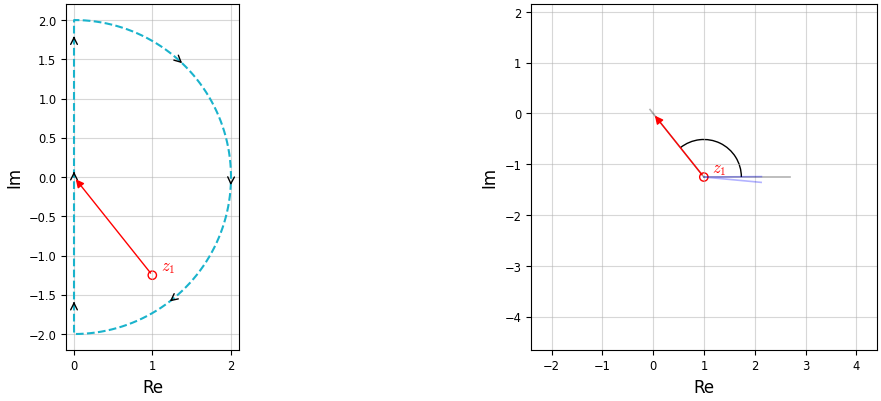

In [77]:
fig3, ax = plt.subplots(1, 2)
drawContour(ax[0], cntr)

## define the zero
z1 = 0.8*R*np.exp(-2/7*np.pi*1j) # You can change me if you'd like

arr, phArc, phl2, r, rm = anim_init(z1, ax)
anim = animation.FuncAnimation(fig3, func=animate, frames=len(Q), interval=50, blit=True)

# plt.close(fig3)
# HTML(anim.to_jshtml())

*Wait...* was that a circle? Actually, that makes sense right? $\Gamma$ goes around $z_1$, so then it has to make a full circle. Woah okay, so $(s-z_1)$ makes a full rotation if (and yes, only if) $z_1$ is on the inside of $\Gamma$, otherwise it just oscilates.

Cool, but this is only for one zero though? What about the others? Well, remember the polynomial
$$ N_F(s) = \prod_{k=1}^Z (s - z_k)?$$
It says here that $N_F(s)$ is the product of a bunch of complex numbers. We know what that means, adding the phases! So any zero inside $\Gamma$ adds a full clockwise encirclement to $N_F(\Gamma)$ (and also $F(\Gamma)$) around **the origin**. What do the outside zeros add though? There are two options: if the zero is real, it splits $\Gamma$ exactly in half and doesn't add any phase overall, if the zero is complex it does add some phase of course. However, complex zeros come in conjugate pairs, so these phase additions cancel out because they are mirrored over the real axis.

How do poles behave here actually? Very similar really, but since the poles are in the denominator of $F(s)$, they subtract phase rather than add. So poles inside $\Gamma$ cause counterclockwise encirclements of the origin.

### I forgot what we were trying to figure out
Yes, me too. Let's run it backwards. We know that zeros inside the contour add a full clockwise rotation and poles add a counterclockwise rotation. If we expand our finite $\Gamma$ to the infinite Nyquist contour $\Gamma_s$, this will encompass all right half plane (RHP) zeros and poles. So the number of clockwise encirclements of the origin of $F(\Gamma_s)$ equals the number of RHP zeros minus the RHP poles. That sounds very familiar! It's similar to the $N=Z-P$ equation, except that is shifted. Realise that
$$F(\Gamma_s) = 1 + L(\Gamma_s),$$
so encirclement of $0+j0$ by $F(\Gamma_s)$ means encirclement of $-1 + j0$ by $L(\Gamma_s)$.

And that's nearly it! Looking back at the practically applicable Nyquist criterion:
> The closed loop is stable if (and only if) the net number of counterclockwise encirclements of $-1+j0$ is equal to the number of RHP poles of $L(s)$.

We're missing one last step. Since $L(s)$ and $F(s)$ share the same poles, and the number of counterclockwise encirclements of $-1+j0$ is equal to the number of these poles in the RHP, the number of CCW encirclements and the number of RHP poles of $L(s)$ from the criterion are only equal if there are no RHP zeros of $F(s)$ adding clockwise encirclements. Then, since there are no RHP zeros of $F(s)$, the closed loop is stable!

And that is why Nyquist works in very rough strokes.

### What if I'm freaky and use positive feedback?
Then the definition of $F(\Gamma_s) = 1 - L(\Gamma_s)$, so then $N$ is the number of encirclements around $1 + j0$. But why would you do that?



## Nyquist vs. Bode, epic rap battles of history

We've seen both Bode plots and the Nyquist plot now. However, just a recap: Bode plots have $s=j\omega$ on the horizontal axes and on the two vertical axes is the magnitude and phase of the transfer function. We've also been looking at magnitude and phase with Nyquist so we must be able to relate the two! Lets look at a dummy transfer function $G(s)$.

---

I just make some plots down here, guiding text still necessary!!!

In [78]:
# cm.reset_rcParams()

s = cm.tf('s')
if True: # Toggle between manual and random
    poles = [0j, -0.05+0.45j, -0.05-0.45j]
    zeros = [-0.6]
    G = 1
    for z in zeros: G *= (s-z)
    for p in poles: G *= 1/(s-p)
else:
    G = cm.rss(states=6)


# G *= 1/(s-0.3)

poles = cm.poles(G)
zeros = cm.zeros(G)
print("G(s) = ")
G


TypeError: unsupported data type: <class 'numpy.complex128'>

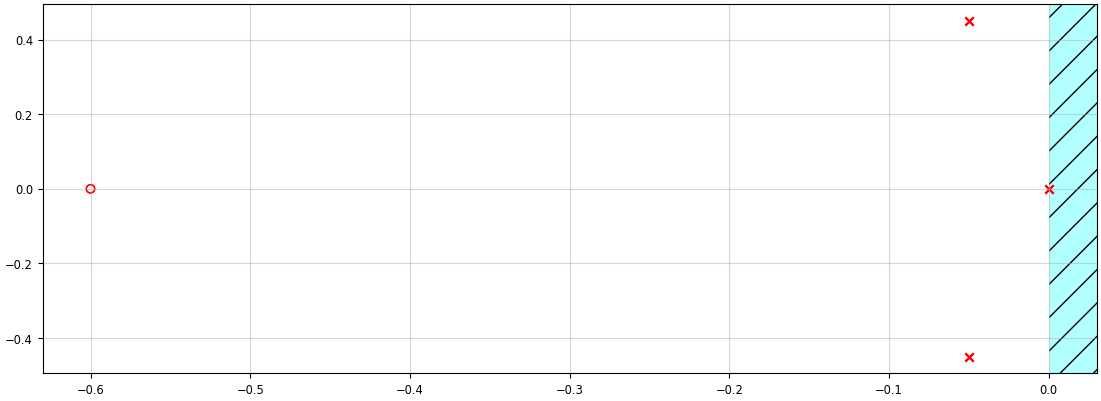

In [ ]:
fig, ax = plt.subplots()
plt.autoscale(True)
ax.scatter(np.real(zeros), np.imag(zeros), marker='o', color='red', facecolors='none')
ax.scatter(np.real(poles), np.imag(poles), marker='x', color='red')
ax.set(xlim=ax.get_xlim(), ylim=ax.get_ylim())
ax.fill_betweenx(ax.get_ylim(), [0], ax.get_xlim()[1], facecolor=[0, 1, 1], alpha=.3, hatch='/')
ax.scatter(np.real(zeros), np.imag(zeros), marker='o', color='red', facecolors='none')
ax.scatter(np.real(poles), np.imag(poles), marker='x', color='red')


2

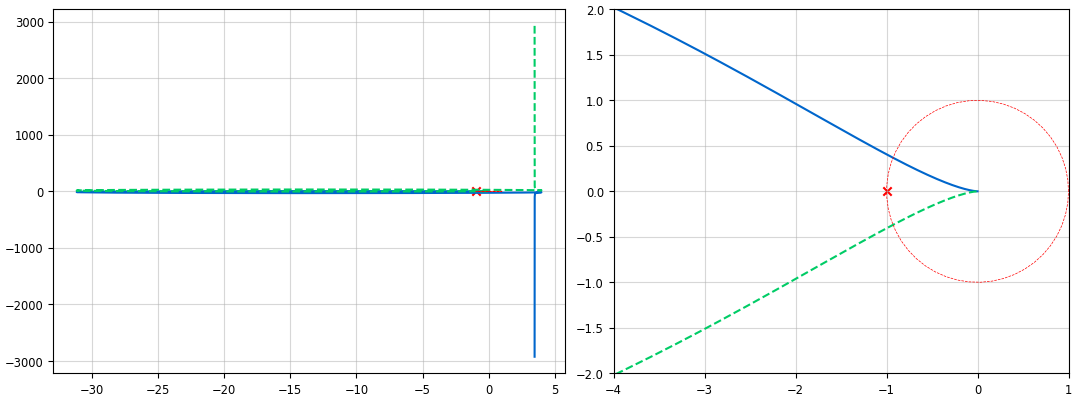

In [ ]:

Nyq = cm.nyquist_response(G)
# Nyq.plot()
r = np.logspace(-3, 2, 1000)*1j# Nyq.contour

G*=1
L = G(r)
uncircle = np.exp(np.linspace(0, np.pi*2)*1j)

fig, ax = plt.subplots(1,2)
for i in range(2):
    ax[i].plot(np.real(L), np.imag(L), color=[0, .4, .8])
    ax[i].plot(np.real(L), -np.imag(L), '--', color=[0, .8, .4])
    ax[i].scatter([-1], [0], marker='x', color='red')
    ax[i].scatter(np.real(G(0j)), np.imag(G(0j)), marker='o', color=[0, .8, .4])
    ax[i].plot(np.real(uncircle), np.imag(uncircle), 'r--', lw=0.5)

    # arrowIdx = np.round(np.linspace(start=0, stop=len(r), num=6, endpoint=False)).astype(int)

    # for idx in range(len(arrowIdx)):
    #     ax[idx].annotate("", xytext=(np.real(L[arrowIdx[idx]]), np.imag(L[arrowIdx[idx]])), 
    #                 xy=(np.real(L[arrowIdx[idx]+1]), np.imag(L[arrowIdx[idx]+1])),
    #                 arrowprops=dict(arrowstyle="->"))

ax[1].set(aspect='equal')
ax[1].set(xlim=(-4, 1), ylim=(-2,2))
Nyq.count

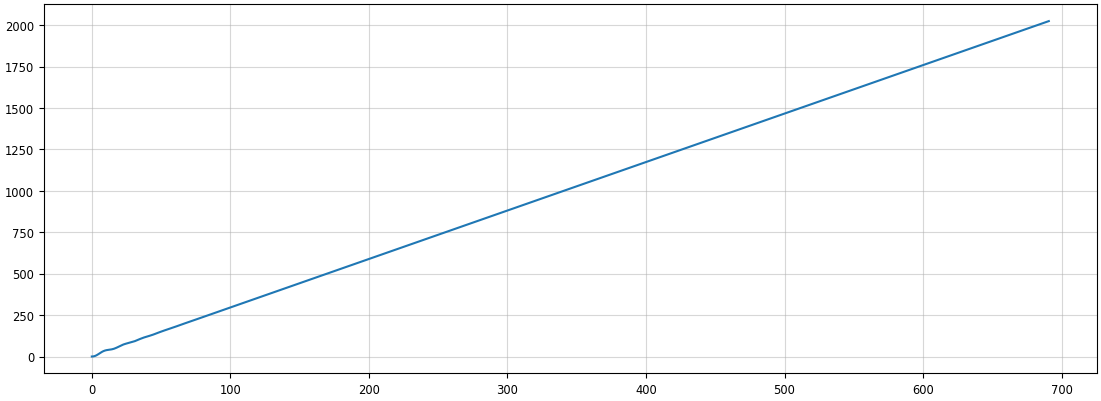

In [ ]:
sysFB = cm.feedback(G)
T, yout = cm.step_response(G)
fig, ax = plt.subplots()
ax.plot(T, yout)